# <span id="chap-er-networks"></span> ER networks

In this chapter we'll explore the ideas that underlie complex networks at both the mathematical (analytic) and computer science (simulation) levels. We'll do this for a good reason: in the real world, networks often cannot be guaranteed to have exactly the properties that the mathematical techniques require, but computer simulation really needs to be driven by an understanding of what's going on in network at a fundamental level and how the mathematical features contribute to this behaviour. For these reasons, it's not safe to only understand how to simulate networks: you need to be able at least to follow the mathematical analysis as well. Conversely, understanding real networks and applications requires the techniques of simulation as well as analysis.

In the [last chapter](concepts.ipynb) we dealt with decidedly un-complex networks &ndash; meshes &ndash; but in this chapter we'll focus on perhaps the simplest kind of complex network, the Erd&#337;s-R&eacute;nyi network, for three reasons:

1. It was the first complex network to be explored in detail
1. It provides a useful initial model for many real-world networks of interest
1. It is sufficiently simple that we can perform simulation and mathematical analysis from first principles

We'll start by building ER networks using `NetworkX` and explore some of the properties that we developed [earlier](concepts.ipynb). We'll then look at the same properties (and more) from a more mathematical perspective, and relate the code to the maths to show how the two views interrelate. 

## <span id="sec_er_building"></span> Building an ER network

For a network with $N$ nodes, an Erd&#337;s-R&eacute;nyi (or ER) network is constructed as follows:

1. Build a graph $G = (V, E)$ with $N$ nodes (also known as vertices) and no edges, so $|V| = N$ and $E = \emptyset$
1. For each pair of nodes $v_1, v_2 \in V$ with $v_1 \neq v_2$, add an edge $(v_1, v_2)$ to $E$ with probability $\phi$

There are a couple of things to notice here. Firstly, the ER model has two parameters: the number of nodes in the network $N$, and the probability $\phi$ of an edge occurring between any given pair of nodes. Secondly, the probability of an edge appearing is independent of everything else: it doesn't matter whether a node is already heavily connected or not, the chances of its being linked to any other node is just $\phi$, and this doesn't change over time. Thirdly, we disallow both self-loops and parallele edges.

We can build an ER model in two ways using `NetworkX`:

1. By implementing the growth process ourselves
1. By using the built-in generator function

Just for demonstration purposes, we'll do both.

In [1]:
import networkx as nx
import math
import numpy as np
import numpy.random as rnd

To define the growth process we need two things: the number of nodes, and the probaility that there will be an edge between any given pair. Given these two numbers we can implement the growth process described above:

In [2]:
def erdos_renyi_graph_from_scratch( n, pEdge ):
    """Build the graph with n nodes and a probability pEdge of there
    being an edge between any pair of nodes."""
    g = nx.empty_graph(n)
    
    # run through all the possible edges
    for i in xrange(n):
        for j in xrange(i + 1, n):
            if rnd.random() <= pEdge:
                g.add_edge(i, j)
    
    return g

Notice the way we run through the pairs of nodes so that we only try to generate an edge between each pair once. This works because the graph we're building is undirected and we want at most one edge between each pair of nodes *in either order*. (If we were building a directed ER network we'd want to try each pair *in each order* to allow for directionality.)

We can then use this function to build an ER network, for example with 5000 nodes and a 5% probability of there being an edge between any pair of nodes:

In [3]:
g_from_scratch = erdos_renyi_graph_from_scratch(5000, 0.05)

Actually we needn't bother building a function capturing the Erd&#337;s-R&eacute;nyi process as `NetworkX` has one built-in that we can use to build a graph with the same properties as above:

In [4]:
g_from_generator = nx.erdos_renyi_graph(5000, 0.05)

## How the graph grows

It can sometimes be useful to see how these graphs evolve, although it has to be said that this becomes less effective as graphs get larger. However, we can use `matplotlib` to draw a graph progressively, one node at a time, and show how the edge set grows too. 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cmx
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

We can then use the `JSAnimation` plug-in to generate an in-line animation, or save the animation to a file and link to it.

In [6]:
from matplotlib import animation

def animate_growing_graph( g, fig, pos = None, **kwords ):
    """Animate a graph, adding nodes one at a time and the edges between
    them. Slow if done for a large graph. Returns a matplotlib animation object
    that can be saved to a file for later or shown in-line in a notebook.
    
    g: the network
    fig: the figure to draw into
    pos: (optional) the position within the figure"""
    
    # manipulate the axes, since this isn't a data plot
    ax = fig.gca()
    ax.set_xlim([-0.2, 1.2])      # axes bounded around 1
    ax.set_ylim([-0.2, 1.2])
    ax.grid(False)                # no grid
    ax.get_xaxis().set_ticks([])  # no ticks on the axes
    ax.get_yaxis().set_ticks([])
    
    # if we're not given an explicit geometry, use the spring layout
    if pos == None:
        pos = nx.spring_layout(g, iterations = 100, k = 2/math.sqrt(g.order()))

    # generate node markers based on positions
    nodeMarkers = []
    for v in g.nodes_iter():
        circ = plt.Circle(pos[v], radius = 0.02, zorder = 2)   # top of the z-order
        ax.add_patch(circ)
        
        # find all edges whose endpoints are in the list already, i.e., that
        # can be drawn with both endpoints present when we draw this node
        es = []
        for (s, t) in g.edges(v):
            if s == v:
                o = t
            else:
                o = s
            if len([ nm for nm in nodeMarkers if nm['node'] == o ]) > 0:
                xs = [ pos[s][0], pos[t][0] ]
                ys = [ pos[s][1], pos[t][1] ]
                line = plt.Line2D(xs, ys, zorder = 1)   # down the z-order
                ax.add_line(line)
                es.append(line)
        nodeMarkers.append({ 'node': v, 'marker': circ, 'edges': es })
        
    # work out the "shape" of the animation
    nFrames = kwords['frames']
    framesPerNodeAndEdges = nFrames / g.order()
    framesPerNode = int((framesPerNodeAndEdges + 0.0) * 0.3)
    framesPerEdges = int((framesPerNodeAndEdges + 0.0) * 0.4)
    framesPerGap = int((framesPerNodeAndEdges + 0.0) * 0.3)
    
    # initialisation function for animation makes everything transparent
    def init():
        for nm in nodeMarkers:
            nm['marker'].set(alpha = 0)
            for e in nm['edges']:
                e.set(alpha = 0)

    # per-frame drawing for animation
    def frame( f ):
        # frame number boundaries for various transitions in the animation "shape"
        atNode = int((f + 0.0) / framesPerNodeAndEdges)
        slot = framesPerNodeAndEdges * atNode
        framesIntoGap = min(f - slot, framesPerGap)
        framesIntoNode = max(0, min(f - slot - framesPerGap, framesPerNode))
        framesIntoEdges = max(0, min(f - slot - framesPerGap - framesPerNode, framesPerEdges))
        intoGap = (framesIntoGap + 0.0) / framesPerGap
        intoNode = (framesIntoNode + 0.0) / framesPerNode
        intoEdges = (framesIntoEdges + 0.0) / framesPerEdges
        
        # make current node progressively visible
        nm = nodeMarkers[atNode]
        if framesIntoNode > 0:
            nm['marker'].set(alpha = intoNode)
            
        # make any of node's edges visible
        if framesIntoEdges > 0:
            for e in nm['edges']:
                e.set(alpha = intoEdges)

    # return the animation with the functions etc set up
    return animation.FuncAnimation(fig, frame, init_func = init, **kwords)

This function generates an animation that we can play to see how things evolve. This is quite a slow process as we have to render each frame of the animation and, if we want to see anything, need to run fairly slowly. We'll use a small ER network to show this process:

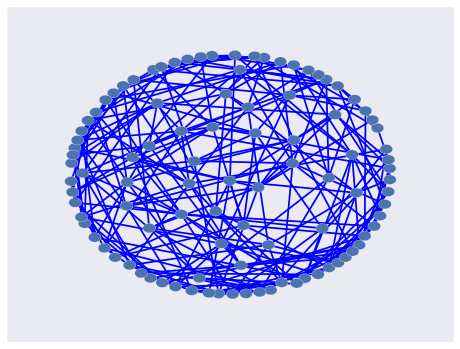

In [7]:
g = nx.erdos_renyi_graph(100, 0.05)

fig = plt.figure(figsize=(8, 6))
anim = animate_growing_graph(g, fig, frames = 600, interval = 25)
anim.save("er-growing.mp4")

This generates the movie and saves it locally using MPEG-4 encoding, suitable for uploading to YouTube or other sites. One I generated earlier lives on YouTube already:

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('8tMCFCkxbnw')

## Properties of the ER model

But this raises a question: how do we *know* that these two functions actually generate ER graphs? One way to answer this is that they just *should*, assuming we built the generator function correctly. But this isn't really satisfactory. A better answer is to look at the properties we expect of an ER network and check that both graphs actually have them, and in the same way.

A moment's thought will expose a problem: what properties *should* we expect from an ER network? We can probably start with the most basic property of a graph: degree distribution. If both approaches generate ER networks, they should have the same degree distribution &ndash; "the same" with the proviso that these are stochastic processes that will not generate exactly the same results at each run. The `pandas` library is designed for data analysis.

In [9]:
# Data anlysis with pandas
import pandas as pd

The easiest place to start with analysing degree distribution is with summary statistics, so it makes sense to load both degree distributions into a data frame first:

In [10]:
deg = pd.DataFrame({'FromScratch': g_from_scratch.degree(),
                    'FromGenerator': g_from_generator.degree()})

We can then let the data frame work out the summary statistics:

In [11]:
print "From scratch ER network, mean = ", deg['FromScratch'].mean()
print "Built-in ER network generator, mean = ", deg['FromGenerator'].mean()

From scratch ER network, mean =  249.7828
Built-in ER network generator, mean =  249.5892


This seems close to the same, but the distribution could be different. To check further, we can plot the degree distributions as histograms:

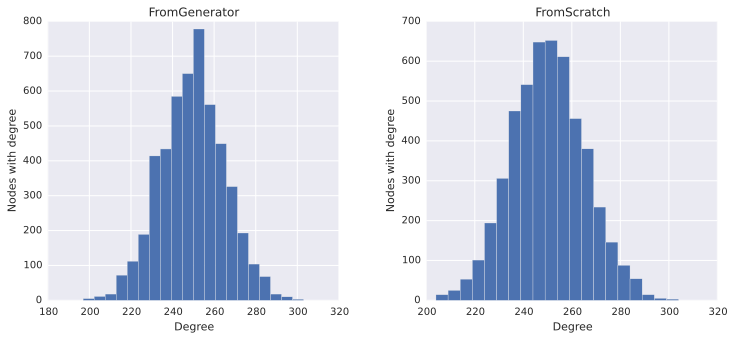

In [12]:
[[ ax_scratch, ax_generator ]] = deg.hist(bins = 20, figsize = (12, 5))
ax_scratch.set_xlabel('Degree');   ax_scratch.set_ylabel('Nodes with degree');
ax_generator.set_xlabel('Degree'); ax_generator.set_ylabel('Nodes with degree');
plt.show()

Are these the same distrubution? They certainly look *roughly* the same &ndash; normal, unimodal, with the same shape and the same mean value &ndash; but that's hardly sufficient. We could plot the ratios of the bins in the two histograms. If the distributions are similar, we'd expect the bins to be the same size, *i.e.*, the ratio to be 1. We can do this as follows:

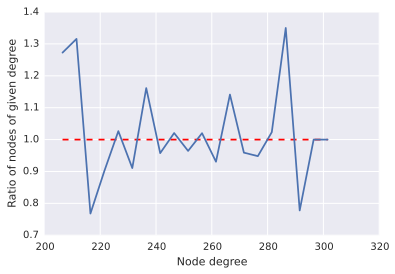

In [13]:
# compute histogram for from-scratch distribution
# capture the histogram data and the bin boundaries
sds, boundaries = np.histogram(g_from_scratch.degree().values(), bins = 20)

# histogram the built-in generator distribution using the same bins
gds, _ = np.histogram(g_from_generator.degree().values(), bins = boundaries)

# compute ratio of from-scratch to built-in values at each bin (ideal = 1)
# (the "+ 0.0" converts the integer bin-counts to floats before computing the ratio)
ds = (sds + 0.0) / (gds + 0.0)

# turn the bin boundaries into bin mid-points suitable for a line graph
midpoints = np.zeros(20)
for i in xrange(len(boundaries) - 1):
    midpoints[i] = boundaries[i] + ((boundaries[i + 1] - boundaries[i]) / 2)

plt.plot()
plt.xlabel("Node degree")
plt.ylabel("Ratio of nodes of given degree")
plt.plot([midpoints[0], midpoints[-1]], [1.0, 1.0], 'r--')
plt.plot(midpoints, ds)
plt.show()

What we've done here is histogram the degree distributions for the two graphs using another `numpy`. The above plot shows that, in the middle of the range where most of the data is, the two distributions pretty much agree: the ratio between them is very close to 1. The differ significantly only at the edges of the distribution, where one network has significantly more nodes with very low or very high degree. That's pretty much as we might expect. We can conclude that &ndash; for these two graphs, anyway &ndash; the two generating processes generate graphs with very similar degree distributions.

To be *really* sure, we can do the same calculation over the averages of multiple networks created using the two processes, and the plot the ratios:

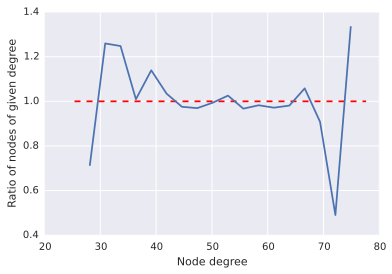

In [14]:
ss = []
for i in xrange(20):
    g = erdos_renyi_graph_from_scratch(1000, 0.05)
    ss = ss + g.degree().values()
sds, boundaries = np.histogram(ss, bins = 20)

gs = []
for i in xrange(20):
    g = nx.erdos_renyi_graph(1000, 0.05)
    gs = gs + g.degree().values()
gds, _ = np.histogram(gs, bins = boundaries)

ds = (sds + 0.0) / (gds + 0.0)

midpoints = np.zeros(20)
for i in xrange(len(boundaries) - 1):
    midpoints[i] = boundaries[i] + ((boundaries[i + 1] - boundaries[i]) / 2)

plt.xlabel("Node degree")
plt.ylabel("Ratio of nodes of given degree")
plt.plot([midpoints[0], midpoints[-1]], [1.0, 1.0], 'r--')
plt.plot(midpoints, ds)
plt.show()

(The actual nodes degrees are smaller because we've averaged over significantly smaller networks in the interests of speed.) Again, the distributions differ significantly only at the edges. We'll therefore conclude that the two generating functions are generating networks with at least the same degree distribution.

Of course there are more properties of interest than just degree distribution, and we should probably check them too &ndash; but we won't, at least not yet. However, although we've slightly belaboured the point, it's an important one: we need to check that the various processes we might use to generate networks do actually generate networks with the properties we need and expect. The only way to be sure of this is to check, using automated techniques that are robust against variations arising from the stochastic nature of the processes involved.

Another question that arises, though, is how we know that the network we're looking at &ndash; the ER network in this case &ndash; *should* have a normally-distributed degree distribution. To understand this we need something more than simulation: we need to understand the mathematics arising from the particular generating process. For this we need to delve into the analysis of statistically-driven processes.

### <span id="sec_er_components"></span> The components of an ER network

The [components](concepts.ipynb#sec_components) of a network are its connected sub-networks. A network may have one or more components. Suppose we construct an ER network: is it connected?

Returning to the way we [created](#sec_er_building) an ER network earlier, we started with an empty network and then added edges between pairs of nodes with a given probability $\phi$. An empty network is maximally disconnected: a $N$-node network will have $N$ components. As we add edges, the number of components will decrease as nodes become connected. But *how fast* does this occur? As we add edges, what happens to the number of components in the network?

The `NetworkX` function `number_connected_components()` computes the number of components in a network. To explore this question, then, we could create a network and progressively add edges to it, counting the number of components as we go. Using our earlier [from-scratch generator](#sec_er_building) is a possibility: however, looking at the code, while the *result* is a random network, the *process* by which edges are added is actually very regular, and we should probably avoid such unnecessary regularity in case it makes a difference. One could easily imagine that adding nodes in a regular fashion might generate components faster (or slower?) than truly random addition.

The network resulting from the generator *is* random, however, so if we took the edges that result and added them to an empty network we would indeed grow the network randomly, with no hint of the regular process by which we decided which edges to add. A permutation function that lets us iterate through a list in random order will do this:

In [3]:
from copy import copy

class permuted:
    """An iterator for the elements of an array in a random order."""
    
    def __init__( self, es ):
        """Return an iterator for the elements of an array in a random order."""
        self.elements = copy(es)            # copy the data to be permuted
    
    def __iter__( self ):
        """Return the iterator."""
        return self
    
    def next( self ):
        """Return a random element."""
        n = len(self.elements)
        if n == 0:
            raise StopIteration
        else:
            i = int(rnd.random() * n)
            v = self.elements[i]
            del self.elements[i]
            return v

We can then write a function that replays a list of edges in random order into another, initially empty, network, computing the number of components as we go:

In [4]:
def growing_component_numbers( n, es ):
    """Build the graph with n nodes and add edges from es, returning
    a list of the number of components in the graph as we add edges in a
    random order taken from a list of possible edges."""

    # create an empty graph
    g = nx.empty_graph(n)

    # add edges to g taken at random from the edge set,
    # and compute components after each edge
    cs = []
    for e in permuted(es):
        g.add_edge(*e)

        nc = nx.number_connected_components(g)
        cs.append(nc)
    return cs

Let's try this on a moderately-sized ER network and plot the number of components against the number of edges:

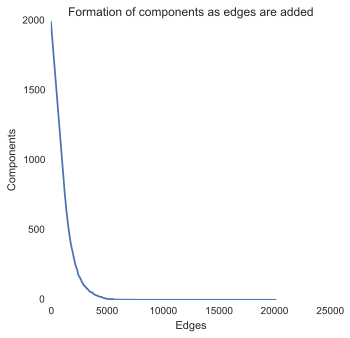

In [5]:
# create an ER networks and grab its edges
er = nx.erdos_renyi_graph(2000, 0.01)
es = er.edges()

# replay these edges
component_number = growing_component_numbers(2000, es)

fig = plt.figure(figsize = (5, 5))
plt.title("Formation of components as edges are added")
plt.xlabel("Edges")
plt.ylabel("Components")
_ = plt.plot(range(len(component_number)), component_number)

So after about 5000 edges have been added &ndash; only about 0.1% of the four million possible edges in the network &ndash; it has already formed a single *giant component* connecting of all the nodes.

How does the giant component form? Does it steadily accrete, or does it form suddenly as previously disconnected components connect? We can explore this by plotting the size of the largest component as we add edges, using the function `connected_components()` that returns a list of components, largest first: 

In [6]:
def growing_component_sizes( n, es ):
    """Build the graph with n nodes and edges taken from es, returning
    a list of the size of the largest component as we add edges in a
    random order taken from a list of possible edges."""
    g = nx.empty_graph(n)

    cs = []
    for e in permuted(es):
        g.add_edge(*e)

        # pick the largest component (the one with the longest list of node members)
        gc = len(max(nx.connected_components(g), key = len))
        
        cs.append(gc)
    return cs

Let's plot the size of the largest component against the number of edges added. Since we know that a giant component forms after about 5000 edges, we can limit ourselves to just plotting this region:

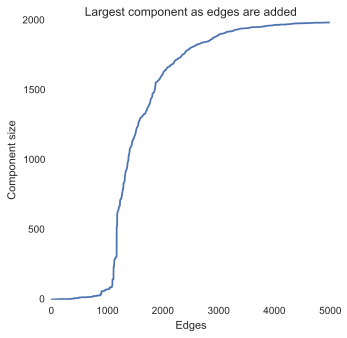

In [7]:
# compute list of component sizes as we add edges, re-using the
# ER edges we computed earlier
component_size = growing_component_sizes(2000, es)

fig = plt.figure(figsize = (5, 5))
plt.title("Largest component as edges are added")
plt.xlabel("Edges")
plt.ylabel("Component size")
_ = plt.plot(range(5000), component_size[:5000])

Now isn't *that* interesting... Let's try to interpret what's happening. Somewhere around 1000 edges &ndash; 0.025% of the possible edges in the network &ndash; well over 50% of the nodes quite suddenly connect and form a giant component. The process by which we're adding edges is random and smooth, but nonetheless results in a sudden change in the connectivity of the network. The network consists of lots of small components that suddenly, over the course of adding a few more edges, join up and create an enormously larger component consisting of most of the nodes. Below this threshold the network is essentially disconnected; above it, it's essentially connected, and becomes completely connected very quickly thereafter.

This is the first example we've seen of a *critical transition* or *phase change*: during a steady, incremental, process, the network changes from one state into another, very different state &ndash; and does so almost instantaneously.

We should examine the area around the critical point in more detail. First we need to locate it. Since the characteristic of the critical point is that the slope of the graph suddenly increases, we can look for it by looking at the slope of the data series: 

In [21]:
def critical_point( cs, slope = 1 ):
    """Find the critical point in a sequence. We define the critical point
    as the index where the derivative of the sequence becomes greater than
    the desired slope. We ignore the direction of the slope."""
    for i in xrange(1, len(cs)):
        if abs(cs[i] - cs[i - 1]) > slope: 
            return i
    return None

We can then plot the vicinity of the critical point to see the critical transition in detail. For clarity we'll plot the size of the largest component and the number of components on the same axes, so we can compare the number of components to the size of the largest in this critical region:

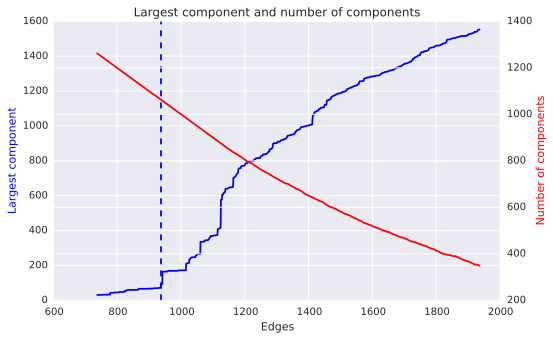

In [22]:
# find the critical point
cp = critical_point(component_size, slope = 10)

# some space either side of the critical point, with the
# right-hand side being more interesting and so getting more
bcp = cp - 200
ucp = cp + 1000

# build a "host" plot and then another one with the same x-axis
fig, sizes = plt.subplots(figsize = (8, 5))
numbers = sizes.twinx()

# label the plot and axes
plt.title("Largest component and number of components")
sizes.set_xlabel("Edges")
sizes.set_ylabel("Largest component")
numbers.set_ylabel("Number of components")

# draw the two data series on their respective sub-plots
sizes_p, = sizes.plot(range(bcp, ucp), component_size[bcp:ucp], 'b')
numbers_p, = numbers.plot(range(bcp, ucp), component_number[bcp:ucp], 'r')

# match the colours of the axes labels to the lines, so we don't
# need a separate colour legend
sizes.yaxis.label.set_color(sizes_p.get_color())
numbers.yaxis.label.set_color(numbers_p.get_color())

# add a line to show where we decided the critical point was
_ = sizes.plot([cp, cp],                          # x's: vertical line at the critical point
               sizes.yaxis.get_view_interval(),   # y's: the y axis' extent
               'b--')

So while the *number of components* comes down fairly smoothly, the *size of the largest component* jumps quickly as smaller components amalgamate.

Let's take a step back. We have explored the critical threshold of a *particular* ER network configuration. Does the giant component always form, regardless of configuration? Or do factors like the mean degree of the network also exert an influence? We coud continue to expore these issues in simulation &ndash; for example by testing the behaviour of several different networks to try to tease-out some regularities &ndash; but this is an example of a behaviour that it's possible to study analytically, at least for ER networks. We'll therefore defer future exploration until a [later section](#sec_er_components_maths) when we have the mathematics we need.

## The mathematics of the ER model

An alternative to simulaton is to analyse a network mathematically, trying to find a closed-form expression for the various properties of interest. We'll focus only on the properties that are most important from a practical perspective: the [Wikipedia page for ER networks](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) describes, but doesn't derive, lots of other properties (of largely theoretical interest). We'll do this from first principles and at some length, to demonstrate the sorts of mathematical argument that'll be common in what's to come.

### <span id="sec_er_networks_degree_distribution"></span> Degree distribution

We'll start with degree distribution: what is the probability of a node $v$ chosen at random having a given degree $k$? In normal probability notaton this would be written $P(deg(v) = k)$, the probability that $deg(v)$, the degree of $v$, is equal to $k$. For brevity we will usually write this as $p_k$. Taken over the whole network, this will yield a degree distribution, where the probability of all possible degrees in the network sum to one: $\sum_k p_k = 1$. So what is the degree distribution for an ER network?

At first acquaintance, many (if not most) non-mathematicians would argue something like this: the probability of including an edge between any pair of nodes is $\phi$, with every edge (and every node) treated equally. Therefore, we'd expect every node to have roughly the same degree as every other &ndash; a degree distribution that's *uniform* &ndash; consistent with the uniformity of the generating process.

Does that sound reasonable? &ndash; it did to me when I first made this argument. But we know from the simulation above that this *isn't* what happens: we actually get a *normal* distribution of degrees, not a uniform one. (If you need more convincing about this, read the rest of this section and then skip to the [epilogue](#sec_epilogue) at the end of the chapter.) Clearly there's another way of thinking about the process.

Let's re-phrase the question: in an ER network, how does a node end up having degree $k$? We can answer this by looking at the construction process. Each node could in principle be connected to $N - 1$ other nodes: that's the maximum number of edges it *could* have, since we've excluded the possibility of self-loops or parallel edges. For each of these potential edges, we essentially tossed a coin to decide whether the edge was included or not &ndash; except that the "coin" came down "heads" with a probability $\phi$ and "tails" with a probability $(1 - \phi)$. Let's refer to each such decision &ndash; add an edge or don't &ndash; as an *action*. For each node there we perform $N - 1$ actions, one per potential edge, and for a node to have a degree $k$ we have to perform $k$ add actions and $N - 1 - k$ don't-add actions. We can perform these actions in any order. We can think of each of the $N - 1$ actions as a *trial* which succeeds when we perform an add action and fails otherwise.

How many ways are there to perform this sequence of actions? Suppose we have a bag of $a$ actions: how many ways are there to select $b$ actions from the bag? The answer to this is given by the formula $\frac{a!}{b! (a - b)!}$, a result known a the *binomial theorem* and denoted $\binom{a}{b}$.

So, returning to our original question, we have $\binom{N - 1}{k}$ ways to perform $k$ add actions from a possible $N - 1$ actions, the remainder being don't-add actions. This is the number of possible sequences that, for a given node, can result in that node having degree $k$. For each potential $N - 1$ edges we perform an action: an add action with probability $\phi$ and a don't-add action with probability $1 - \phi$ since these are the only two possibilities and their probabilities have to add up to $1$. From elementary probability theory, to work out the probability of a sequence of actions happening we multiply-out the probabilities of the individual actions: "this *and* this *and* this" and so forth. So we'll want to take the probabilities of the actions and multiply them together, and then multiply this compound probability by the number of ways it can happen, the number of ways the actions can happen and still give us the $k$ edges we want.

Putting all this together, the probability that a node $v$ taken at random from an ER model consisting of $N$ nodes and edge probability $\phi$ will have degree $k$ is given by:

$$p_k = \binom{N - 1}{k} \phi^k (1 - \phi)^{N - 1 - k}$$

That is to say, we need a sequence consisting of $k$ instances of an add action that occurs with probability $\phi$ *and* $N - 1 - k$ don't-add actions occurring with probability $1 - \phi$, *and* there are $\binom{N - 1}{k}$ ways in which these actions can be arranged.

This is a distribution well known in statistics as the *binomial distribution*. It's important to note that $\phi$ is a constant, and that each "success" (add action) is independent of each other "success": it doesn't get any easier to add edges over time. (If this seems like an obvious thing to say, we only say it because this turns out to be vitally important when we consider BA networks [later](powerlaw.ipynb).)

Given that we are dealing with large graphs, we will simplify the $N - 1$ term to $N$, since it makes little difference as $N \rightarrow \infty$, yielding:

$$p_k = \binom{N}{k} \phi^k (1 - \phi)^{N - k}$$

What happens as $n$ gets larger and larger? Clearly $\binom{N}{k}$ also gets larger and larger (there are more and more ways to choose the $k$ edges), and $(1 - \phi)^{N - k}$ gets smaller and smaller (since $1 - \phi$ is by definition less than $1$), while $\phi^k$ stays the same size. It's not blindingly obvious what happens to the equation, but fortunately the answer *is* known: the binomial distribution converges to another distribution, the *Poisson distribution*, as $N \rightarrow \infty$. The Poisson distribution is basically the normal distribution for systems built from discrete events, and is given by:

$$p_k = \frac{(N\phi)^k e^{-N\phi}}{k!}$$

While this form is easier to work with, it's a lot less suggestive. The binomial form is probably to be preferred as a way of thinking about the distribution simply because each of the factors within it relates to a real, concrete phenomenon: add actions, don't-add actions, their probabilities (summing to 1), and the number of ways of combining them.

### <span id="sec_er_networks_mean_degree_maths"></span> Mean degree

A useful number to know for an ER network is the *mean degree*, the degree of an "average" node. A mean degree of $k$ is usually written $\langle k \rangle$. Plotting a Poisson distribution will help understand where the mean degree comes from:

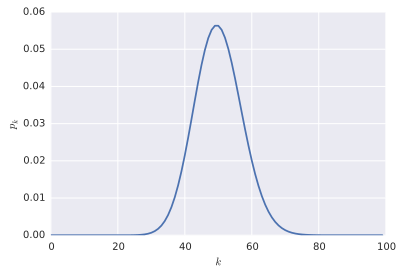

In [25]:
def poisson( n, pEdge ):
    """Return a model function for the Poisson distribution with n nodes and
    edge probability pEdge."""
    def model( k ):
        return (pow(n * pEdge, k) * math.exp(-n * pEdge)) / math.factorial(k)
    return model

fig = plt.figure()
plt.xlabel("$k$")
plt.ylabel("$p_k$")
_ = plt.plot(xrange(100), map(poisson(1000, 0.05), xrange(100)))

The graph is symmetric around the point $x = 50$, suggesting that this is the mean. Looking at the parameters of the distribution, however, we plotted 1000 nodes with an edge probability of 0.05, which multiplied-out also give 50.

In fact the mean of a Poisson distribution is given by $N\phi$. Since the Poisson is an approximation of a binomial for suitably large networks, we can approximate the mean degree of an ER network by $N\phi$: given a number of nodes and an edge probability, we can work out the mean degree. Looking at the equation for the Poisson, we can see that $N$ and $\phi$ are the only parameters: we need to know them, *and only them*, to compute the distribution for any value of $k$. We can therefore say that $N$ and $\phi$ *completely characterise* the distribution.

There is another implication of this, however. Since $\langle k \rangle = N\phi$, we can re-write the probability distribution for at ER network in terms of the network's mean degree:

$$p_k = \frac{\langle k \rangle^k e^{-\langle k \rangle}}{k!}$$

Put another way, we can easily construct a network with a desired mean degree and number of nodes, using these two numbers to derive the necessary edge probability using $\phi = \frac{\langle k \rangle}{N}$.

### Statistical moments

The mean is the simplest example of what is known as a *moment* of a distribution, specifically the *first moment*. Moments try to capture key elements of the "shape" of a distribution. All distributions have a first moment, second moment, and so forth. The idea of a moment is derived from physics, where is relates to the idea of momentum. The first moment of a distribution measures how far an "average" point is from zero. The second moment measures the distance of an "average" point from the mean, and so is an indication of how "spread out" the distribution is.

As with all distributions, the mean degree $\langle k \rangle$ is defined as the *expected value* of the distribution, sometimes written $\mathbb{E}(k)$ and defined by:

\begin{align}
    \mathbb{E}(k) &= 1 \times p_1 + 2 \times p_2 + \cdots \\
                  &= \sum_k k \, p_k
\end{align}

For the Poisson distribution underlying an ER network, we can check that this is approximately the case by working out the expected value for a distribution whose mean we know analytically. If $N = 1000$ and $\phi = 0.05$ then $\langle k \rangle = N\phi = 50$. If we compute this sum for degree up to 100 &ndash; a value well above the mean &ndash; we get:

In [26]:
sum = 0
p = poisson(1000, 0.05)
for k in xrange(1, 100):
    sum = sum + k * p(k)
print sum

49.9999999677


That's a close enough.

Does this number always exist? For an ER network we know from the plot of degree distribution that the probability of having a node with degree $k$ drops-off quickly on either side of the mean. This suggests that the probabilities of high-degree nodes will approach zero, and to the sum for $\mathbb{E}(k)$ will converge. (More rigourously, $\langle k \rangle^k$ grows more slowly than $k!$ and so $p_k \rightarrow 0$ as $k \rightarrow \infty$.)

We can of course calculate the mean degree directly from the observed degrees of the nodes in a network, where

$$
\langle k \rangle = \frac{1}{N} \sum_{i = 1}^{N} \, deg(v_i)
$$

The second moment of the distribution, $\langle k^2 \rangle = \sum_k k^2 \, p_k$, is related to the statistical variance of the degree distribution. More specifically, $\langle k^2 \rangle$ is the *second raw moment*, the variance about zero, while normal statistical usage is to use variance $\sigma^2$ about the mean (the *second central moment*).  We can convert one to the other, since $\sigma^2 = \langle k^2 \rangle - \langle k \rangle^2$. As usual, the (positive) square root of the variance is the *standard deviation* of the distribution.

### Diameter and characteristic path

Two other summary statistics

...

### <span id="sec_er_components_maths"></span> The critical threshold and the giant component

When we looked at components [earlier](#sec_er_components), we discovered that a "giant" component forms rapidly as we add edges to the network. The location of this critical threshold can be determined analytically, removing the need for simulation. How this is done is another useful illustration of mathematical reasoning applied to networks.

Suppose we have a network with $N$ nodes and edge probability $\phi$, and suppose further that this network has a giant component. How does a node $i$ come to *not* be in the giant component? This happens when $i$ is not adjacent to a node that *is* in the giant component. That means that, for every other node $j$ in the network, either:

* $i$ is not linked to $j$; or
* $i$ is linked to $j$, but $j$ is also not in the giant component

Let $u$ denote the fraction of nodes that are not in the giant component. In an ER network, this means that $u$ is also the probability that a node chosen at random is not in the giant component. We can use $u$ to capture the two cases above. The probability that $i$ is not adjacent to $j$ is simply $1 - \phi$, the probability of not having made an edge between $i$ and $j$. The probability that a node $j$ adjacent to $i$ is not in the giant component is $\phi u$, the probability of there being ad edge between $i$ and $j$ *and* that $j$ is not in the giant component. Therefore the total probability of a random node $i$ not being in the giant component is given by the sum of these two probabilities, $1 - \phi + \phi u$. We know that $i$ has $N - 1$ other nodes to connect to, or approximately $N$ in the limit of a large network, so we find the probability of a node $i$ not being in the giant component as:

\begin{align*}
    u &= (1 - \phi + \phi u)^N \\
      &= (1 - \phi(1 - u))^N \\
      &= \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg )^N
\end{align*}

(making use of $\phi = \frac{\langle k \rangle}{N}$ from [above](#sec_er_mean_degree_maths)). Notice that $u$ appears on both sides of the equation. If we take logs we get:

\begin{align*}
    \log u &= N \log \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg ) \\
           &= -N \frac{\langle k \rangle}{N} (1 - u) \\
           &= -\langle k \rangle(1 - u)
\end{align*}

and so:

$$
    u = e^{-\langle k \rangle(1 - u)}
$$

It's perhaps awkward to reason in terms of the fraction of nodes *not in* the giant component, so if we denote the fraction of nodes that *are in* the giant component by $S = 1 - u$ then we can re-arrange this expression to get:

$$
    S = 1 - e^{-\langle k \rangle S}
$$

Again we have $S$ on both side. If we re-arrange to solve for $\langle k \rangle$, we get:

\begin{align*}
                S - 1 &= - e^{-\langle k \rangle S} \\
                1 - S &= e^{-\langle k \rangle S} \\
         \log (1 - S) &= -\langle k \rangle S \\
    \langle k \rangle &= - \frac{\log (1 - S)}{S}
\end{align*}

What does all this mean? To find solutions for $S$, the fractional size of the giant component for different mean degrees,  we have to fall back on graphical means, plotting $y = 1 - e^{-\langle k \rangle S}$ for different values of $\langle k \rangle$. The solutions are then where these curves meets the line $y = S$. We show this in the left-hand plot below. In the right-hand plot we  show the size of the giant component for different values of $\langle k \rangle$.

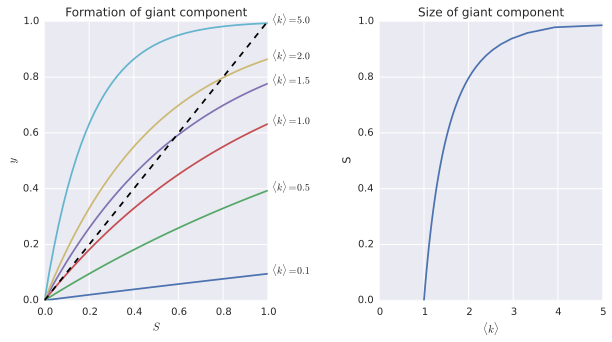

In [27]:
# y = 1 - e^{<k> S} for some parameter <k>
def make_er_giant_component_fraction( kmean ):
    def model( S ):
        return 1 - math.exp(-kmean * S)
    return model

# y = log(1 - S) / S
def er_giant_component_degree( S ):
    return -(math.log(1 - S) / S)

# plot along the closed interval (0, 1)
ss = np.linspace(0.001, 0.999)

# create a figure with two side-by-side sub-plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = .5)                   # a bit more space between sub-plots

# plot the formation of the giant component
ax[0].set_title('Formation of giant component')
ax[0].set_xlabel('$S$')
ax[0].set_ylabel('$y$')

# plot the fraction S for some different values of <k>
for kmean in [0.1, 0.5, 1.0, 1.5, 2.0, 5.0]:
    gcf = make_er_giant_component_fraction(kmean)
    _ = ax[0].plot(ss, map(gcf, ss))
    
    # label each curve off to the right of the graph axes,
    # at the same height as the end of the curve
    ax[0].text(1.02, gcf(0.999), '$\\langle k \\rangle = ' + str(kmean) + '$')

# add the solution line y = S
ax[0].plot([0, 1], [0, 1], 'k--', label = '$y = S$')

# plot the fraction S of the giant component as a function of <k>
ax[1].set_xlim([0, 5])
ax[1].set_title('Size of giant component')
ax[1].set_xlabel('$\\langle k \\rangle$')
ax[1].set_ylabel('S')
_ = ax[1].plot(map(er_giant_component_degree, ss), ss)

There are two messages from these graphs. On the left-hand side, different values of $\langle k \rangle$ give different size of giant component. The curve for $\langle k \rangle = 2$, for example, results in $S = 0.8$: the giant component will occupy four-fifths of the nodes. For $\langle k \rangle < 1$, no giant component will form at all. On the right-hand side, the size of the giant component asymptotically approaches 1 as $\langle k \rangle$ increases.

We should check these results experimentally, just to be sure:

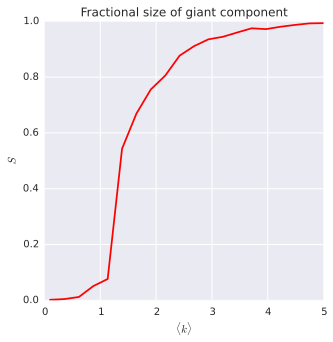

In [28]:
def make_er_giant_component_size_by_kmean( n ):
    """Return a model function for a network with the given number
    of nodes, computing the fractional size of the giant component
    for different mean degrees."""
    def model( kmean ):
        phi = kmean / n
        er = nx.erdos_renyi_graph(n, phi)
        gc = len(max(nx.connected_components(er), key = len))
        S = (gc + 0.0) / n
        return S
    return model

fig = plt.figure(figsize = (5, 5))
plt.title('Fractional size of giant component')
plt.xlabel('$\\langle k \\rangle$')
plt.ylabel('$S$')
kmeans = np.linspace(0.1, 5.0, num = 20)
_ = plt.plot(kmeans, map(make_er_giant_component_size_by_kmean(2000), kmeans), 'r-')

You'll notice this curve doesn't exactly follow what the analytical solution would suggest: we seem to get take-off slightly before $\langle k \rangle = 1$, and the curve isn't smooth. The analytical model is expressed in terms of averages, while the graph above is generated from *one specific* ER network that *might* happen to have properties that cause a giant component to form, or not form, or form with a slightly different size than predicted, just becase of some fluke of the edges. The mathematical expression gives us the expected behaviour that's overwhemingly probable in the case of large ($N \rightarrow \infty$) networks but can be misleading in smaller networks.  

### Excess degree

Suppose we select a node at random, then select an edge at random, and traverse it: what would we expect the degree of the node we arrive at to be? The obvious answer might be $\langle k \rangle$: is that correct? Put another way, what is the degree distribution of neighbours of a node? 

A randomly-selected node in an ER network will be expected to have degree $\langle k \rangle$, by definition, However &ndash; perhaps surprisingly &ndash; this doesn't imply that a *neighbouring node selected at random* will also have degree $\langle k \rangle$. Nodes with high degree are easier to reach than other nodes &ndash; they have more incident edges &ndash; so a neigbouring node is somewhat more likely to have higher degree than normal. We'll explore this mathematically and then computationally.

In almost all the networks we'll consider in this book, we disallow parallel edges (two edges with the same endpoints) and self-loops (edges that start and end on the same node). This means that each edge is incident on two, different, nodes, and that each edge contributes to the degree of these two nodes. This implies that, if there are $M$ edges in the network, $\sum_v deg(v) = 2M$. Suppose we choose a random node $v$ and a random edge $e$ leaving $v$. There are $2M - 1$ places that the other end of $e$ can attach to in the network, and $k$ of them are on a *particular* node of degree $k$, so the probability of $e$ being attached to a *particular* node of degree $k$ is $\frac{k}{2M - 1} \approx \frac{k}{2M}$. Given that there are $N \, p_k$ nodes of degree $k$ in the network, the probability of $e$ attaching to *any* node of degree $k$ is given by:

$$
\frac{k}{2M} N \, p_k = \frac{N}{2M} k \, p_k
$$

However, it is also the case that $2M = N \langle k \rangle$ &ndash; there are $N$ times the mean degree of attachment points for edges. Therefore the probability that a randomly-chosen node is adjacent to a node of degree $k$ is given by

$$
\frac{k \, p_k}{\langle k \rangle}
$$

Put another way, the probability of reaching a node of degree $k$ is proportional to $k \, p_k$, not simply proportional to the frequency of nodes of degree $k$ is in the network as a whole, to compensate for the fact that higher-degree nodes are adjacent to relatively more nodes than lower-degree nodes. 

What, then is the average degree of the neighbour of a randomly-chosen node? We can get this by multiplying out the probabilities for all values of $k$, giving:

\begin{align*}
    \sum_k k \frac{k \, p_k}{\langle k \rangle}
    &= \frac{\sum_k k^2 \, p_k}{\langle k \rangle} \\
    &= \frac{\langle k^2 \rangle}{\langle k \rangle}
\end{align*}

(Using the definition of the second moment from earlier.) This leads to the surprising conclusion that the average degree of the neighbour of a randomly-chosen node is not the same as that of a randomly-chosen node itself. In fact we can express it simply in terms of the variance from above:

\begin{align*}
    \frac{\langle k^2 \rangle}{\langle k \rangle} - \langle k \rangle
    &= \frac{1}{\langle k \rangle} ({\langle k^2 \rangle} - {\langle k \rangle^2}) \\
    &= \frac{\sigma^2}{\langle k \rangle}
\end{align*}

Since $\langle k \rangle$ is always positive, and since $\sigma^2$ is always non-negative (and strictly greater than zero if there is any variation at all in the degrees of nodes), this implies that $\frac{\langle k^2 \rangle}{\langle k \rangle} > {\langle k \rangle}$.

The number of edges attached to a neighbouring node excluding the edge we traversed to get there (*i.e.*i, the one that makes it adjacent in the first place) is referred to as the *excess degree* of the node, and is by definition one less than the degree of the neighbouring node. If we denote the probability of a node having excess degree $k$ by $q_k$, we can then define the probability distribution of excess degree in the network, which is the same as a node having degree $k + 1$, which is simply:

$$
q_k = \frac{(k + 1) \, p_k}{\langle k \rangle}
$$

using the probability we derived above. To be clear: $p_k$ is the probability of a node selected at random having degree $k$; $q_k$ is the probability of a neighbouring node having *excess* degree $k$ (degree $k + 1$).

In random graphs like the ER network, $q_k$ is uncorrelated with the degree of the initial node chosen. This often isn't true for real-world networks, where it may be the case that, for example, high-degree nodes have neighbours that are themselves more likely to be high-degree. In that case, $q_k$ would be correlated with the degree of the initial node, and the computation would have to reflect this correlation. It is important to remember that a lot of the simplifications we have made above, using mean degrees and second moments, rely on the underlying randomness &ndash; that is to say, un-correlatedness &ndash; of the node degrees, and if these assumptions aren't met the calculations will yield the wrong results.

## Summary

In this chapter we've looked at two approaches to complex network modelling: using simulation within `NetworkX`, and mathematically using the Poisson distribution and mean degree. These two approaches are complementary, and it's important to understand both so they can be used appropriately. Also, the approaches used for the ER network are pretty much standard for other, more complex networks that have richer structures.

## <span id="sec_epilogue"</span> Epilogue: why *isn't* the degree distribution uniform?

Earlier we asserted that many people, on first seeing the generating process for the ER model, assume that it will result in a uniform degree distribution. I certainly did. Since it's such a common reaction, it's perhaps worth exploring a little why it's also wrong.

The argument for a uniform degree distribution goes roughly as follows: since the edge probability is independent for every edge, we'd expect that, at each node, we select roughly the same number of edges to add, and therefore there's no reason for one node to be preferred over another, so they should all have roughly the same degree.

The problem here is that it takes a statement about *edges* and subtly converts it into a statement about *nodes*. Just because we select edges with a constant probability doesn't imply that we do so uniformly at the node level &ndash; so uniformly, in fact, that every node ends up having *exactly* the same number of edges. Put that way, a uniform degree distribution actually sounds rather unlikely! The process only says that, *over the graph as a whole*, edges are added with constant probability: it does not say anything about the *local* behaviour of edge addition around an individual node. It is this that allows for the possibility of non-uniform distrbution.

This observation &ndash; that global behaviour, and typically global regularity, doesn't lead to local regularity &ndash; is perhaps the single most important thing to bear in mind about complex networks. It's tempting to think that large-scale regularity emerges from lots of small-scale regularity, but that isn't necessarily the case: the small scale could be irregular, but the irregularities could even out. Conversely, it's tempting to think that something that looks regular and well-behaved on the outside has component pieces that are regular and well-behaved &ndash; and again that isn't necessarily the case. The lesson here is that things can be more complex than they seem. On the other hand, it also means that we can often ignore local noise and make use of global properties, as long as we're careful.

The description we used for the ER generator is an example of a process that in mathematics is called a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_process), where we look at the sequence of actions needed to generate a given outcome and compute how many ways there are for those actions to occur at random. Bernoulli processes occur whenever we encounter actions being performed one after the other according to some random driver, and the [argument above](#sec_er_degree_distribution) is completely typical of how one deals with them.